In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [67]:
transform = transforms.Compose(
    [transforms.ToTensor(), # convert to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # image = (image - mean) / std
     transforms.RandomHorizontalFlip(), # randomly flipping images for data augmentation
     transforms.RandomVerticalFlip(),
     transforms.ColorJitter()]) # randomly adjusts color

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


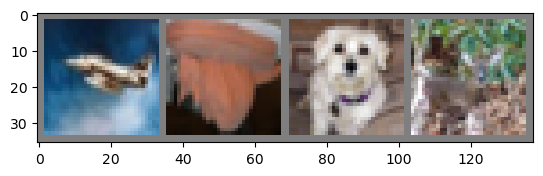

plane cat dog deer


In [68]:
def show(image):
    image = image / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[i]]}' for i in range(batch_size)))

In [69]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.conv2 = nn.Conv2d(9, 27, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(27 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [70]:
criterion = nn.CrossEntropyLoss() # loss calculated by cross entropy since it is a classification problem
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # stochastic gradient descent

for epoch in range(3):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
print('Done')

Done


In [71]:
PATH = './cifar_net_1.pth'
torch.save(net.state_dict(), PATH)

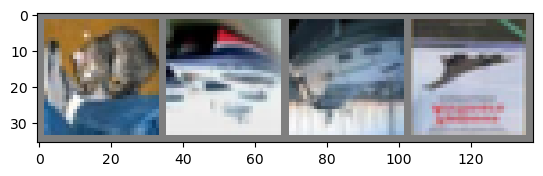

Correct Labels: cat ship ship plane


In [77]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show(torchvision.utils.make_grid(images))
print('Correct Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [73]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [74]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

Predicted: horse ship ship plane


In [75]:
correct, total = 0, 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in testloader:
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

Accuracy: 54 %


In [76]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for {classname:5s} -- {accuracy:.1f} %')

Accuracy for plane -- 57.0 %
Accuracy for car   -- 77.3 %
Accuracy for bird  -- 46.9 %
Accuracy for cat   -- 26.3 %
Accuracy for deer  -- 52.1 %
Accuracy for dog   -- 41.0 %
Accuracy for frog  -- 76.5 %
Accuracy for horse -- 55.7 %
Accuracy for ship  -- 70.6 %
Accuracy for truck -- 46.6 %
